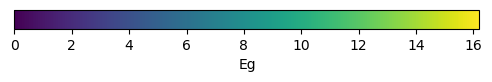

In [3]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scripts.track_pairs import *
from scripts.show_tracks import *

def show_colorbar(cmap='viridis', vmin=0, vmax=6, label='Eg'):
    fig, ax = plt.subplots(figsize=(6, 0.5))
    fig.subplots_adjust(bottom=0.5)

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(cmap=plt.colormaps[cmap], norm=norm)
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.set_label(label, fontsize=10)
    plt.show()

def plot_on_folium(df, c='Eg', cmap='viridis', zoom_start=12, background = 'OpenStreetMap'):
    # Drop any invalid data just in case
    df = df.dropna(subset=['latitude', 'longitude', c])
    df = df[np.isfinite(df[c])]

    # Set vmin and vmax
    vmin = 0
    vmax = df[c].max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    colormap = plt.colormaps[cmap]

    # Center map on average coordinates
    lat_center = df['latitude'].mean()
    lon_center = df['longitude'].mean()
    m = folium.Map(location=[lat_center, lon_center], zoom_start=zoom_start, tiles='OpenStreetMap')

    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=False,
        control=True
    ).add_to(m)

    # Plot each point
    for _, row in df.iterrows():
        color = colormap(norm(row[c]))
        hex_color = colors.to_hex(color)
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=2,
            color=hex_color,
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    return m

dirpath = '../scratch/data/underc/'
all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
# coords = (-104.6920, 53.9163) # old_jack_pine ALT 451
coords = (-89.5373, 46.2339) # underc ALT 520
# coords = (-90.0791, 45.8060) # willow creek ALT 521

# ax = plt.gca()
big_df = show_tracks([all_ATL03[i] for i in [8]], [all_ATL08[i] for i in [8]], coords, altitude=521, c='Eg', CBAR=None, gtx=[1,3,5], landcover='forest',rebinned=30)

# print(big_df)

vmin = 0
vmax = big_df['Eg'].max()

show_colorbar(cmap='viridis', vmin=vmin, vmax=vmax, label='Eg')

map_ = plot_on_folium(big_df, c='Eg', background = 'OpenStreetMap')
# map_.save('icesat_ojp_segments.html')
from IPython.display import display
display(map_)